In [10]:
ls'./Historical Data/NOAAdailynormal.csv'

./Historical Data/NOAAdailynormal.csv


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


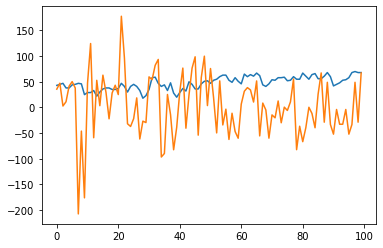

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os

convertfunc = lambda x: float(x.strip(b'"'))

#use for loops
coi="DailyAverageRelativeHumidity"
dailyavgdew=np.genfromtxt(os.path.join('./Historical Data/LCM.csv'), names=True, skip_header=1,
                delimiter=",",   deletechars="",
                autostrip=True, converters={coi :convertfunc}, usecols=coi)

# dailyavgdew = dailyavgdew[np.logical_not(np.isnan(dailyavgdew))]
# plt.plot(dailyavgdew)

# dailyavgdewfourier = np.fft.fft(dailyavgdew)
# plt.plot(dailyavgdewfourier)

dailyavgdew = dailyavgdew[np.logical_not(np.isnan(dailyavgdew))]
plt.plot(dailyavgdew[90:190])

dailyavgdewfourier = np.fft.fft(dailyavgdew)
plt.plot(dailyavgdewfourier[90:190])


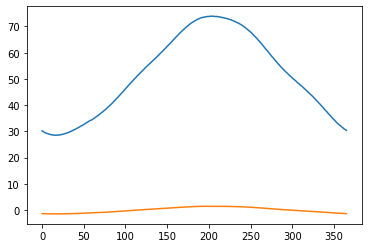

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
convertfunc = lambda x: float(x.strip(b'"'))
#use for loops
coi="DLY-TAVG-STDDEV"
dailyavg=np.genfromtxt(os.path.join('./Historical Data/NOAAdailynormal.csv'), names=True, delimiter=",",   
                   deletechars="",autostrip=True, converters={coi :convertfunc}, 
                   usecols=coi)

plt.plot(dailyavg)
dailyavgmean=np.mean(dailyavg)
sd=np.std(dailyavg)
normalizeddata=(dailyavg-dailyavgmean)/sd
#plt.plot(dailyavg)
plt.plot(normalizeddata)


['daynumber', 'driftadvantage', 'betadvantage']
(100, 50)
(100,)


ValueError: not enough values to unpack (expected 2, got 1)

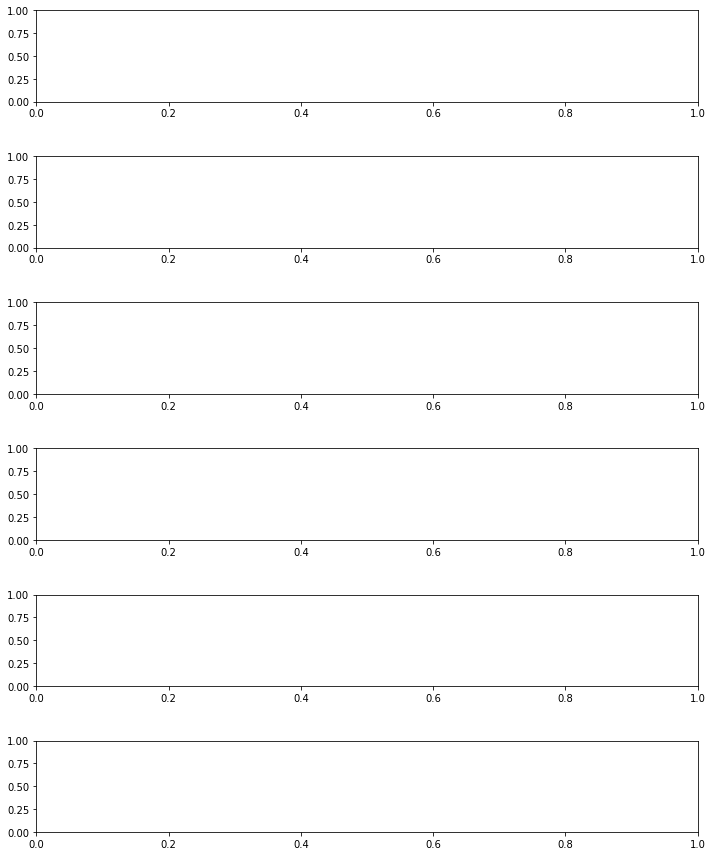

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os

def npzgraph(driftvariance, betadvantage):
    #np.savez('Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'.npz')
    data=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'.npz'))
    dataparameters=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'parameters.npz'))
    #dataenvi=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'envi.npz'))
    #datapref=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'pref.npz'))
    print(data.files)
    
    print(np.shape(dataparameters['envi']))
    print(np.shape(dailyavgdew[90:190]))

    fig, (ax0, ax1,  ax1d, ax2, ax3, ax4) = plt.subplots(6, 1)
    fig.set_figwidth(10)
    fig.set_figheight(12)
    fig.tight_layout()
    plt.subplots_adjust(hspace=.6)
    #c=ax0.pcolormesh(dataparameters['envi'])
    c=ax0.pcolormesh(dailyavgdew[90:190])
    fig.colorbar(c,ax=ax0)
    ax0.set_title('Environment (color is fraction of flies of given pref survive)')
    ax0.set_ylabel('Preference')
    ax0.set_xlabel('Day')

    c=ax1.pcolormesh(dataparameters['pref2'])
    fig.colorbar(c,ax=ax1)
    ax1.set_title('Fly Preference (color is log(num) flies each day)')
    ax1.set_ylabel('Preference')
    ax1.set_xlabel('Day')

    c=ax1d.pcolormesh(dataparameters['pref2']/np.max(dataparameters['pref2'],axis=0))
    fig.colorbar(c,ax=ax1d)
    ax1d.set_title('Fly Preference Distribution (color is %daily flies)')
    ax1d.set_ylabel('Preference')
    ax1d.set_xlabel('Day')

    ax2.plot(np.log(dataparameters['pref02']))
    ax2.set_title('total log(num) flies)') # lowest value is 0.0001 (prefvariance = 0.01 with percent bh=0.01)
    ax2.set_ylabel('log(num) flies)')
    ax2.set_xlabel('Day')
    ax2.set_xlim(0,max(data['daynumber']+1))

    # ax3.plot(driftadvantage)
    ax3.plot(data['driftadvantage']/dataparameters['pref02'])
    ax3.set_title('Change in death rate due to last day\'s drift ')
    ax3.set_ylabel('∆surviving flies/total flies')
    ax3.set_xlabel('Day')
    ax3.set_xlim(0,max(data['daynumber']+1))

    ax4.plot(data['betadvantage']/dataparameters['pref02'])
    ax4.set_title('Change in death rate due to last day\'s bethedging ')
    ax4.set_ylabel('∆surviving flies/total flies')
    ax4.set_xlabel('Day')
    ax4.set_xlim(0,max(data['daynumber']+1))

    fig.colorbar(c,ax=ax2)
    fig.colorbar(c,ax=ax3)
    fig.colorbar(c,ax=ax4)

    fig.suptitle('Bet-hedge variance: '+str(dataparameters['prefvariance'])+', Drift variance: '+str(dataparameters['driftvariance'])+', Adaptive Tracking: '+str(dataparameters['adaptivetracking']), y=-.05, fontsize=16)

    plt.show()

npzgraph(0.2,0.0)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

bhlower=0
bhupper=2
bhinterval=10
driftlower=0
driftupper=.2
driftinterval=10
   
def npzheatmap(driftvariance, betadvantage,bhlower, bhupper, bhinterval, driftlower, driftupper, driftinterval, runindex=0, saveloc='none'):
    data=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'.npz'))
    dataparameters=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'parameters.npz'))

    prefmean=dataparameters['prefmean']
    birthrate=dataparameters['birthrate']
    matureage=dataparameters['matureage']
    percentbh=dataparameters['percentbh']
    adaptivetracking=dataparameters['adaptivetracking']
    showgraphs=False

    figuresavepath='Heat Maps'
    prefvariance=np.linspace(bhlower, bhupper, bhinterval)
    driftvariance=np.linspace(driftlower, driftupper, driftinterval)

    numruns=bhinterval*driftinterval

    flatmatrix=np.zeros(numruns)

    flatmatrix[:]=Parallel(n_jobs=-1, verbose=10)((sd.driftmodeling)(dataparameters['envi'], dataparameters['prefmean'], [dataparameters['prefvariance'][n%bhinterval]], [dataparameters['driftvariance'][math.floor(n/bhinterval)]], dataparameters['adaptivetracking'], dataparameters['birthrate'],dataparameters['matureage'],dataparameters['percentbh'], showgraphs, figuresavepath) for n in range(numruns))
    
    matrix=np.zeros((bhinterval,driftinterval))
    matrix[:,:]=flatmatrix.reshape((bhinterval, driftinterval), order='F')
    matrixlog=np.log(matrix)\


    bhmargin=(bhupper-bhlower)/(bhinterval-1)/2
    driftmargin=(driftupper-driftlower)/(driftinterval-1)/2
    prefvariancemesh=np.linspace(bhlower-bhmargin, bhupper+bhmargin, bhinterval+1)
    driftvariancemesh=np.linspace(driftlower-driftmargin, driftupper+driftmargin, driftinterval+1)
 
    fig,ax=plt.subplots()
    scale=max(-np.min(matrixlog),np.max(matrixlog))
    c=ax.pcolormesh(driftvariancemesh, prefvariancemesh, matrixlog, shading='flat', cmap='RdBu',  vmin=-scale, vmax=scale)

    ax.set_xlabel('Drift')
    ax.set_ylabel('Bet-Hedging')
    fig.colorbar(c, ax=ax)
    ax.set_title('Log of Final Population')
    plt.show

    if os.path.exists(figuresavepath) and saveloc=='none':
        print('none=not saving, no valid path')
    if os.path.exists(figuresavepath) and saveloc=='npz':
        heatmapname='R'+str(runindex)+'_heatmap.png'
        fig.savefig(os.path.join(figuresavepath,heatmapname),bbox_inches='tight', pad_inches=.3)
        filename='R'+str(runindex)+'_Env_FinalPopulations.npz'
        np.savez(os.path.join(figuresavepath,filename), finalpopulations=matrix, prefvariancemesh=prefvariancemesh, driftvariancemesh=driftvariancemesh, envi=envi)
        print(figuresavepath)
    if os.path.exists(figuresavepath) and saveloc=='csv':
        heatmapname='R'+str(runindex)+'_heatmap.png'
        fig.savefig(os.path.join(figuresavepath,heatmapname),bbox_inches='tight', pad_inches=.3)
        filename='R'+str(runindex)+'_Env_FinalPopulations.csv'
        np.savez(os.path.join(figuresavepath,filename), finalpopulations=matrix, prefvariancemesh=prefvariancemesh, driftvariancemesh=driftvariancemesh, envi=envi)
        print(figuresavepath)
    if os.path.exists(figuresavepath) and saveloc=='both':
        heatmapname='R'+str(runindex)+'_heatmap.png'
        fig.savefig(os.path.join(figuresavepath,heatmapname),bbox_inches='tight', pad_inches=.3)
        filename='R'+str(runindex)+'_Env_FinalPopulations.npz'
        np.savez(os.path.join(figuresavepath,filename), finalpopulations=matrix, prefvariancemesh=prefvariancemesh, driftvariancemesh=driftvariancemesh, envi=envi)
        print(figuresavepath)
        heatmapname='R'+str(runindex)+'_heatmap.png'
        fig.savefig(os.path.join(figuresavepath,heatmapname),bbox_inches='tight', pad_inches=.3)
        filename='R'+str(runindex)+'_Env_FinalPopulations.csv'
        np.savez(os.path.join(figuresavepath,filename), finalpopulations=matrix, prefvariancemesh=prefvariancemesh, driftvariancemesh=driftvariancemesh, envi=envi)
        print(figuresavepath)
    else:
        print('error, no valid path for specified saveloc')

    return matrix, driftvariance, prefvariance

npzheatmap(0.2,0.0,bhlower, bhupper, bhinterval, driftlower, driftupper, driftinterval)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


NameError: name 'sd' is not defined

['finalpopulations', 'envifull', 'envimean', 'y_prefvariancemesh', 'x_driftvariancemesh']


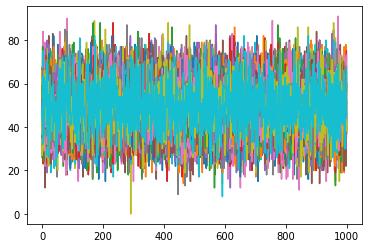

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sci
import matplotlib.pyplot as plt
import time
import math
import os
import scipy.stats as stat
import colorednoise as cn
import csv

x=np.load('/Users/athenaye/Desktop/FinalPopulationAndEnv1000runs_2_20_21.npz')
print(x.files)
plt.plot(x['envimean'])